<a href="https://colab.research.google.com/github/ZoryAce/Topicos/blob/main/notebooks/CNN-PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Computer Vision using Pytorch

This section runs through the API for common tasks in machine learning.
Refer to the links in each section to dive deeper.

Working with data
-----------------

PyTorch has two [primitives to work with
data](https://pytorch.org/docs/stable/data.html):
`torch.utils.data.DataLoader` and `torch.utils.data.Dataset`. `Dataset`
stores the samples and their corresponding labels, and `DataLoader`
wraps an iterable around the `Dataset`.


In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

PyTorch offers domain-specific libraries such as
[TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and
[TorchAudio](https://pytorch.org/audio/stable/index.html), all of which
include datasets. For this tutorial, we will be using a TorchVision
dataset.

The `torchvision.datasets` module contains `Dataset` objects for many
real-world vision data like CIFAR, COCO ([full list
here](https://pytorch.org/vision/stable/datasets.html)).

Now, we use the FashionMNIST dataset. Every TorchVision `Dataset`
includes two arguments: `transform` and `target_transform` to modify the
samples and labels respectively.


In [4]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 200kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.73MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.57MB/s]


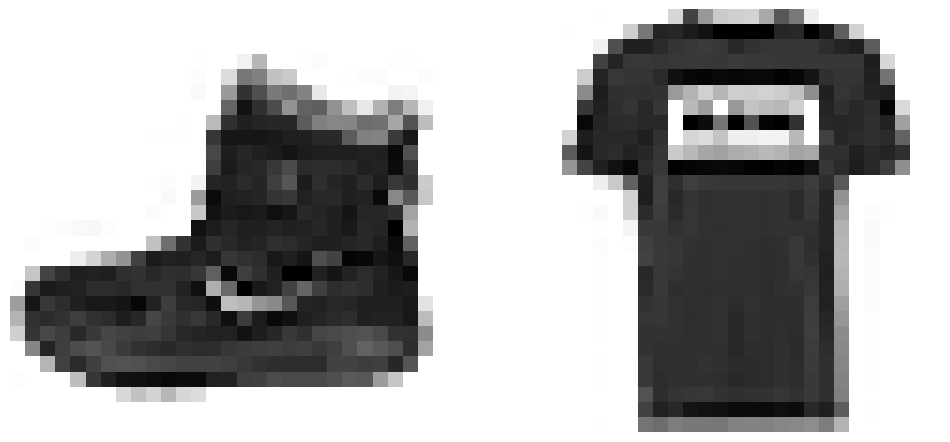

In [5]:
plt.figure(figsize=(12, 8))
for image_idx in (0, 1):
    plt.subplot(1, 2, image_idx + 1)
    plt.imshow(training_data[image_idx][0].squeeze(), cmap="binary")
    plt.axis("off")

plt.show()

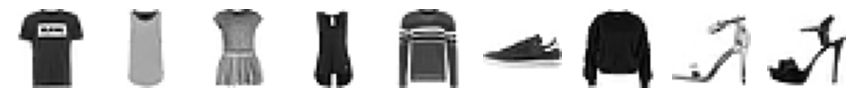

In [6]:
plt.figure(figsize=(12, 8))
for image_idx in range(1,10):
    plt.subplot(1, 10, image_idx + 1)
    plt.imshow(training_data[image_idx][0].squeeze(), cmap="binary")
    plt.axis("off")

plt.show()

We pass the `Dataset` as an argument to `DataLoader`. This wraps an
iterable over our dataset, and supports automatic batching, sampling,
shuffling and multiprocess data loading. Here we define a batch size of
64, i.e. each element in the dataloader iterable will return a batch of
64 features and labels.


In [7]:
training_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [8]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## Creating Models

To define a neural network in PyTorch, we create a class that inherits
from
[nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
We define the layers of the network in the `__init__` function and
specify how data will pass through the network in the `forward`
function. To accelerate operations in the neural network, we move it to
the GPU or MPS if available.


In [9]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(#grupo de capas
            nn.Linear(28*28, 512),#tamaño del array del flatten
            nn.ReLU(),
            nn.Linear(512, 512),#512 neuronas
            nn.ReLU(),
            nn.Linear(512, 10)#10neuronas debe ser softmax
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Optimizing the Model Parameters

To train a model, we need a [loss
function](https://pytorch.org/docs/stable/nn.html#loss-functions) and an
[optimizer](https://pytorch.org/docs/stable/optim.html).


In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training
dataset (fed to it in batches), and backpropagates the prediction error
to adjust the model\'s parameters.


In [11]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()#vector de gradietes en 0 la siguiente iteracion no tenga gradientes actualizados

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model\'s performance against the test dataset to
ensure it is learning.


In [12]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (*epochs*).
During each epoch, the model learns parameters to make better
predictions. We print the model\'s accuracy and loss at each epoch;
we\'d like to see the accuracy increase and the loss decrease with every
epoch.


In [13]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.297922  [   64/60000]
loss: 2.291567  [ 6464/60000]
loss: 2.272453  [12864/60000]
loss: 2.270971  [19264/60000]
loss: 2.255222  [25664/60000]
loss: 2.227774  [32064/60000]
loss: 2.237106  [38464/60000]
loss: 2.200532  [44864/60000]
loss: 2.209093  [51264/60000]
loss: 2.170998  [57664/60000]
Test Error: 
 Accuracy: 43.3%, Avg loss: 2.167878 

Epoch 2
-------------------------------
loss: 2.174208  [   64/60000]
loss: 2.171395  [ 6464/60000]
loss: 2.116001  [12864/60000]
loss: 2.135309  [19264/60000]
loss: 2.091315  [25664/60000]
loss: 2.029670  [32064/60000]
loss: 2.063067  [38464/60000]
loss: 1.982379  [44864/60000]
loss: 2.000699  [51264/60000]
loss: 1.924827  [57664/60000]
Test Error: 
 Accuracy: 57.2%, Avg loss: 1.920310 

Epoch 3
-------------------------------
loss: 1.941751  [   64/60000]
loss: 1.924681  [ 6464/60000]
loss: 1.806991  [12864/60000]
loss: 1.856201  [19264/60000]
loss: 1.755145  [25664/60000]
loss: 1.686017  [32064/600

## Saving Models

A common way to save a model is to serialize the internal state
dictionary (containing the model parameters).


In [14]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Loading Models

The process for loading a model includes re-creating the model structure
and loading the state dictionary into it.


In [15]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

This model can now be used to make predictions.


In [16]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


## Convolutional Neural Network

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, padding=3)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=256 * 3 * 3, out_features=128)  # Adapt input size if necessary
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=10)
        # Dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Convolutional and pooling layers
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        # Flatten the output
        x = torch.flatten(x, 1)
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        # Output layer
        x = self.fc3(x)
        return x


In [18]:
# Instantiate and print the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNet().to(device)
print(model)

ConvNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [19]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.300774  [   64/60000]
loss: 2.305492  [ 6464/60000]
loss: 2.309287  [12864/60000]
loss: 2.300490  [19264/60000]
loss: 2.318086  [25664/60000]
loss: 2.311104  [32064/60000]
loss: 2.299732  [38464/60000]
loss: 2.312932  [44864/60000]
loss: 2.301224  [51264/60000]
loss: 2.309359  [57664/60000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.305350 

Epoch 2
-------------------------------
loss: 2.298944  [   64/60000]
loss: 2.294247  [ 6464/60000]
loss: 2.306292  [12864/60000]
loss: 2.297127  [19264/60000]
loss: 2.315254  [25664/60000]
loss: 2.307476  [32064/60000]
loss: 2.305571  [38464/60000]
loss: 2.313572  [44864/60000]
loss: 2.300166  [51264/60000]
loss: 2.317186  [57664/60000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.305350 

Epoch 3
-------------------------------
loss: 2.298748  [   64/60000]
loss: 2.303972  [ 6464/60000]
loss: 2.307654  [12864/60000]
loss: 2.300053  [19264/60000]
loss: 2.313392  [25664/60000]
loss: 2.307559  [32064/600